# 2.2 Smoothing

Images can exhibit different levels of *noise*: a random variation of brightness or color information. It is mainly produced by factors like the sensor response (more in CMOS technology), analog-to-digital conversion, *dead* sensor pixels, or bit errors in transmission, among others.

There are two typical types of noise:

- **Salt & pepper** noise (black and white pixels in random locations of the image) or **impulse** noise (only white pixels)

- **Gaussian** noise (intensities are affected by an additive zero-mean Gaussian error).

<img src="./images/noise.png" width="800"> 

In this section, we are going to learn about some smoothing techniques aiming to eliminate or reduce such noise, including:

- Convolution-based methods
  - Neighborhood averaging
  - Gaussian filter
- Median filter
- Image average

## Problem context - Number-plate recognition

<img src="./images/access_system.png" width="400">

Returning to the parking access problem proposed by UMA, they were grateful with your previous work. However, after some testing of your code, there were some complaints about binarization because it is not working as well as they expected. It is suspected that the found difficulties are caused by image noise. The camera that is being used in the system is having some problems, so different types of noise are appearing in its captured images. 

This way, UMA asked you again to provide some help with this problem!

In [1]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interactive, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
import random

images_path = './images/'

### **<span style="color:green"><b><i>ASSIGNMENT 1: Taking a look at images</i></b></span>**

First, **display the images** `noisy_1.jpg` and `noisy_2.jpg` and try to detect why binarization is in trouble when processing them.


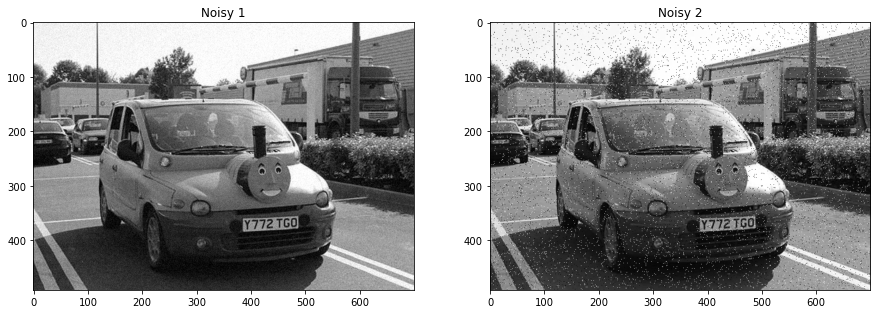

In [2]:
# ASSIGNMENT 1
# Read 'noisy_1.jpg' and 'noisy_2.jpg' images and display them in a 1x2 plot
# Write your code here!

# Read images
noisy_1 = cv2.imread(images_path + 'noisy_1.jpg', 0)
noisy_2 = cv2.imread(images_path + 'noisy_2.jpg', 0)

# Display first one
plt.subplot(121)
plt.imshow(noisy_1, cmap='gray')
plt.title('Noisy 1')

# Display second one
plt.subplot(122)
plt.imshow(noisy_2, cmap='gray')
plt.title('Noisy 2')

plt.show()

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Once you displayed both images, **answer the following questions:**

- What is the difference between them?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Noisy 1. Podemos apreciar que esta imagen se ve algo borrosa, lo cual es un claro indicador de que contiene cierto grado de Ruido Gaussiano.</i></p>
<p style="margin: 4px 0px 6px 5px; color:blue"><i>Noisy 2. Salta a la vista que los puntos blancos y negros esparcidos por la imagen de manera aleatoria son indicadores del Ruido de Sal y Pimienta.</i></p>

- Why can this happen?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>- El Ruido Gaussiano está asociado con las pertubaciones ocasianadas por radiaciones electromagnéticas o por pequeñas imprecisiones en los sensores de la cámara a la hora de capturar la imagen, como es una mala iluminación.</i></p>
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>- El Ruido de Sal y Pimienta es producido por repentinas e intensas perturbaciones que ocasionan este punteado blanco y negro de pixeles a lo largo de la imagen de manera aleatoria.</i></p>

## 2.2.1 Convolution-based methods

There are some interesting smoothing techniques based on the convolution, a mathematical operation that can help you to alleviate problems caused by image noise. Two good examples are **neighborhood averaging** and **Gaussian filter**.

### a) Neighborhood averaging

Convolving an image with a *small* kernel is similar to apply a function over all the image. For example, by using convolution it is possible to apply the first smoothing operator that you are going to try, **neighborhood averaging**. This operator averages the intensity values of pixels surrounding a given one, efficiently removing noise. Formally:

$S(i,j) = \frac{1}{p} \sum_{(m,n)\in s} I(m,n)$

with $s$ being the set of $p$ pixels in the neighborhood ($m x n$) of $(i,j)$. Convolution permits us to implement it using a kernel, resulting in a linear operation! For example, a kernel for a 3x3 neighborhood would be:

<table>
	<tbody>
		<tr>
			<td style="border: 1px solid;">1/9</td>
			<td style="border: 1px solid;">1/9</td>
			<td style="border: 1px solid;">1/9</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1/9</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">1/9</td>
			<td style="border: 1px solid;">1/9</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1/9</td>
			<td style="border: 1px solid;">1/9</td>
			<td style="border: 1px solid;">1/9</td>
		</tr>
	</tbody>
</table>

You can think that the kernel is like a weight matrix for neighbor pixels, and convolution like a double `for` loop that applies the kernel pixel by pixel over the image. 

Not everything will be perfect, and the **main drawback** of neighborhood averaging is the blurring of the edges appearing in the image. 

### **<span style="color:green"><b><i>ASSIGNMENT 2: Applying average filtering</i></b></span>**

Complete the method `average_filter()` that convolves an input image using a kernel which values depend on its size (e.g. for a size 3x3 size its values are 1/9, for a 5x5 size 1/25 and so on). Then display the differences between the original image and the resultant one if `verbose` is `True`. It takes the image and kernel aperture size as input and returns the smoothed image.

*Tip: OpenCV defines the 2D-convolution [cv2.filter2D(src, ddepth, kernel)](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04) method, where:*
- *the `ddepth` parameter means desired depth of the destination image.*
    - *Input images (`src`) use to be 8-bit unsigned integer (`ddepth`=cv2.CV_8U).*
    - *However, output sometimes is required to be 16-bit signed (`ddepth`=cv2.CV_16S)*

In [3]:
# ASSIGNMENT 2
# Implement a function that applies an 'average filter' to an input image. The kernel size of the filter is also an input. 
# Show the input image and the resulting one in a 1x2 plot.
def average_filter(image, w_kernel, verbose=True):
    """ Applies neighborhood averaging to an image and display the result.  
    
        Args:
            image: Input image
            w_kernel: Kernel aperture size (1 for a 3x3 kernel, 2 for a 5x5, etc.)
            verbose: Only show images if this is True
            
        Returns:
            smoothed_img: smoothed image 
    """
    # Write your code here!
    
    # Create the kernel
    height = 2*w_kernel+1 # or number of rows
    width = 2*w_kernel+1 # or number of columns
    kernel = np.ones((height, width), np.float32)/(height*width)
    
    # Convolve image and kernel
    smoothed_img = cv2.filter2D(image,cv2.CV_8U,kernel)
    
    if verbose:
        # Show the initial image
        plt.subplot(121)
        plt.title('Noisy')
        plt.imshow(image, cmap='gray')

        # Show the resultant one
        plt.subplot(122)
        plt.title('Average filter')
        plt.imshow(smoothed_img, cmap='gray')
    
    return smoothed_img

You can use the next snippet of code to **test if your results are correct**:

[[ 9 12  9 12]
 [ 8 10  8 10]
 [ 7 10  8 11]
 [ 5  7  6  8]]


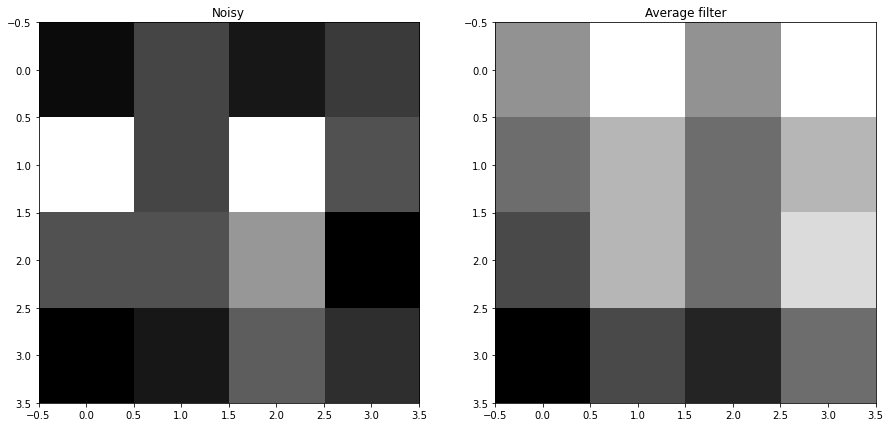

In [4]:
# Try this code
image = np.array([[1,6,2,5],[22,6,22,7],[7,7,13,0],[0,2,8,4]], dtype=np.uint8)
w_kernel = 1
print(average_filter(image, w_kernel))

<font color='blue'>**Expected output:**  </font>

    [[ 9 12  9 12]  
    [  8 10  8 10]  
    [  7 10  8 11]  
    [  5  7  6  8]]

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

**You are asked to** use the code cell below (the interactive one) and try **average_filter** using both noisy images `noisy_1.jpg` and `noisy_2.jpg`. Then, **answer the following questions**:

- Is the noise removed from the first image?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Con valores altos del parámetro 'w_kernel' somos capaces de reducir en gran medida el ruido de la imagen a costa de suavizar los bordes en exceso. Esto resulta en una imagen con menor ruido Gausiano pero con mayor dificultad de reconocimiento de objetos debido a dicho enturbiamento.</i></p>

- Is the noise removed from the second image?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>A diferencia del anterior, esta imagen requiere indudablemente de valores muy altos del parámetro para reducir el ruido de Sal y Pimienta que contiene. Si queremos quitarlo, deberemos de pagar un alto precio suavizando tanto la imagen que resulta menos clarificadora que en un principio.</i></p>

- Which value is a good choice for `w_kernel`? Why?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Para la primera imagen con un valor de 1 es suficiente, pero para la segunda requeriremos de al menos un valor igual a 3.</i></p>

In [5]:
# Interact with the kernel size
noisy_img = cv2.imread(images_path + 'noisy_2.jpg', 0)
interactive(average_filter, image=fixed(noisy_img), w_kernel=(0,5,1), verbose=fixed(True))

interactive(children=(IntSlider(value=2, description='w_kernel', max=5), Output()), _dom_classes=('widget-inte…

### b) Gaussian filtering 

An alternative to neighborhood averaging is **Gaussian filtering**. This technique applies the same tool as averaging (a convolution operation) but with a more complex kernel.

The idea is to take advantage of the normal distribution for creating a kernel that keeps borders in the image while smoothing. This is done by giving more relevance to the pixels that are closer to the kernel center, creating a **neighborhood weighted averaging**. For example, considering a kernel with an aperture of 2 ($5\times5$ size), its values would be:

<table>
	<tbody>
		<tr>
			<td style="border: 1px solid;">0.003</td>
			<td style="border: 1px solid;">0.013</td>
			<td style="border: 1px solid;">0.022</td>
            <td style="border: 1px solid;">0.013</td>
            <td style="border: 1px solid;">0.003</td>
		</tr>
        <tr>
			<td style="border: 1px solid;">0.013</td>
			<td style="border: 1px solid;">0.059</td>
			<td style="border: 1px solid;">0.097</td>
            <td style="border: 1px solid;">0.059</td>
            <td style="border: 1px solid;">0.013</td>
		</tr>
		<tr>
            <td style="border: 1px solid;">0.022</td>
			<td style="border: 1px solid;">0.097</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">0.159</td>
			<td style="border: 1px solid;">0.097</td>
            <td style="border: 1px solid;">0.022</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0.013</td>
			<td style="border: 1px solid;">0.059</td>
			<td style="border: 1px solid;">0.097</td>
            <td style="border: 1px solid;">0.059</td>
            <td style="border: 1px solid;">0.013</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0.003</td>
			<td style="border: 1px solid;">0.013</td>
			<td style="border: 1px solid;">0.022</td>
            <td style="border: 1px solid;">0.013</td>
            <td style="border: 1px solid;">0.003</td>
		</tr>        
	</tbody>
</table>


For defining such a kernel it is used the Gaussian bell:

In 1-D:
$$g_{\sigma}(x) = \frac{1}{\sigma\sqrt{2\pi}}exp\left(-\frac{x^2}{2\sigma^2}\right)$$

In 2-D, we can make use of the *separability property* to separate rows and columns, resulting in convolutions of two 1D kernels:
$$g_{\sigma}(x,y) = \underbrace{\frac{1}{2\pi\sigma^2}exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)}_{g}
= \underbrace{\frac{1}{\sigma\sqrt{2\pi}}exp\left(-\frac{x^2}{2\sigma^2}\right)}_{g_x}*
\underbrace{\frac{1}{\sigma\sqrt{2\pi}}exp\left(-\frac{y^2}{2\sigma^2}\right)}_{g_y}
$$

For example: 

<div style="margin: 0 auto; text-align: center; display: table;">

<div style = "padding: 10px; display: table-cell; vertical-align: middle;">$g=g_y\otimes g_x\rightarrow$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">2</td>
			<td style="border: 1px solid;">1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">2</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">4</td>
			<td style="border: 1px solid;">2</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">2</td>
			<td style="border: 1px solid;">1</td>
		</tr>
	</tbody>
</table> 
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle;"> $=$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;" bgcolor="#81F7F3">2</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
		</tr>
	</tbody>
</table>
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle;"> $\otimes$ </div>
    
<table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">2</td>
			<td style="border: 1px solid;">1</td>
		</tr>
	</tbody>
</table>
</div>

And because of the *associative property*:

$$\underbrace{f \otimes g}_{\text{2D convolution}} =
f \otimes (g_x \otimes g_y) = \underbrace{(f \otimes g_x) \otimes g_y}_{\text{Two 1D convolutions}}$$

In this way, we do $2n$ operations instead of $n^2$, being $n$ the kernel size. This is relevant in kernels with a big size!

The degree of smoothing of this filter can be controlled by the $\sigma$ parameter, that is, the **standard deviation** of the Gaussian distribution used to build the kernel. The bigger the $\sigma$, the more smoothing, but it could result in a blurrier image!

The $\sigma$ parameter also influences the **kernel aperture** value to use, since it must be proportional. It has to be big enough to account for non-negligible values in the kernel! For example, in the kernel below, it doesn't make sense to increase its aperture (currently $1$) since new rows/columns would have very small values:

<table>
	<tbody>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">15</td>
			<td style="border: 1px solid;">1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">15</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">100</td>
			<td style="border: 1px solid;">15</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">15</td>
			<td style="border: 1px solid;">1</td>
		</tr>
	</tbody>
</table> 

### **<span style="color:green"><b><i>ASSIGNMENT 3: Implementing the famous gaussian filter</i></b></span>**

Complete the `gaussian_filter()` method in a similar way to the previous one, but including a new input: `sigma`, representing the standard deviation of the Gaussian distribution used for building the kernel. 

As an illustrative example of separability, we will obtain the kernel by performing the convolution of a 1D `vertical_kernel` with a 1D `horizontal_kernel`, resulting in the 2D gaussian `kernel`!

*Tip: Note that NumPy defines mathematical functions that operate over arrays like [exponential](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html) or [square-root](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sqrt.html), as well as mathematical [constants](https://docs.scipy.org/doc/numpy/reference/constants.html) like `np.pi`. Remember the associative property of convolution*.

*Tip 2: The code below uses **List Comprehension** for creating a list of numbers by evaluating an expression within a `for` loop. Its syntax is: `[expression for item in list]`. You can find multiple examples of how to create lists using this technique on the [internet](http://www.google.com/search?q=python+list+comprehension).*

In [6]:
# ASSIGNMENT 3
# Implement a function that:
# -- creates a 2D Gaussian filter (tip: it can be done by implementing a 1D Gaussian filter and doing the outer product of the 1D kernel with itself)
# -- convolves the input image with the kernel
# -- displays the input image and the filtered one in a 1x2 plot (if verbose=True)
# -- returns the smoothed image
def gaussian_filter(image, w_kernel, sigma, verbose=True):
    """ Applies Gaussian filter to an image and display it.   

        Args:
            image: Input image
            w_kernel: Kernel aperture size
            sigma: standard deviation of Gaussian distribution
            verbose: Only show images if this is True
        
        Returns:
            smoothed_img: smoothed image 
    """
    # Write your code here!
    
    # Create kernel using associative property
    s = sigma
    w = w_kernel
    kernel_1D = np.float32([np.exp(-z*z/(2*s*s))/(np.sqrt(2*np.pi)*s) for z in range(-w,w+1)]) # Evaluate the gaussian in "expression"
    vertical_kernel = kernel_1D.reshape(2*w+1,1) # Reshape it as a matrix with just one column
    horizontal_kernel = kernel_1D.reshape(1,2*w+1) # Reshape it as a matrix with just one row
    kernel = signal.convolve2d(vertical_kernel, horizontal_kernel) # Get the 2D kernel

    # Convolve image and kernel
    smoothed_img = cv2.filter2D(image,cv2.CV_8U,kernel)
    
    if verbose:
        # Show the initial image
        plt.subplot(121)
        plt.imshow(image, cmap='gray')
        plt.title('Noisy')

        # Show the resultant one
        plt.subplot(122)
        plt.imshow(smoothed_img, cmap='gray')
        plt.title('Gaussian filter')
    
    return smoothed_img

Again, you can use next code to **test if your results are correct**:

[[5 6 7 8]
 [5 7 7 8]
 [4 6 7 7]
 [3 5 5 5]]


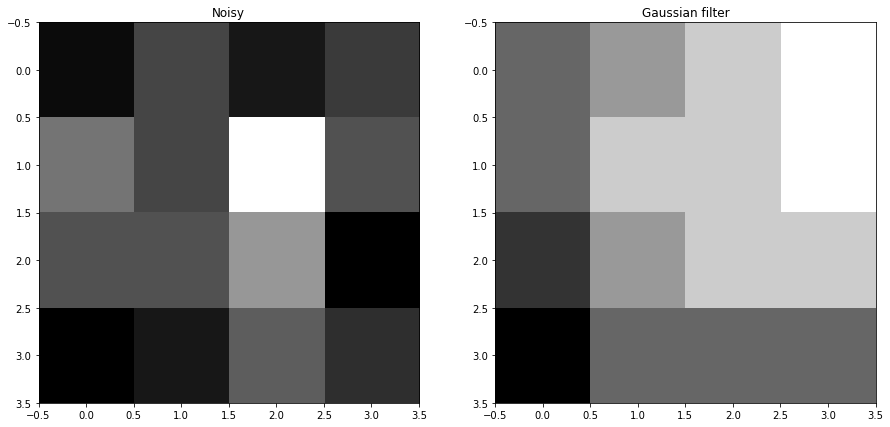

In [7]:
image = np.array([[1,6,2,5],[10,6,22,7],[7,7,13,0],[0,2,8,4]], dtype=np.uint8)
w_kernel = 1
sigma = 1
print(gaussian_filter(image, w_kernel,sigma))

### <font color='blue'>**Expected output:**  </font>

    [[5 6 7 8]
     [5 7 7 8]
     [4 6 7 7]
     [3 5 5 5]]

### <font color="blue"><b><i>Thinking about it (3)</i></b></font>

**You are asked to** try **gaussian_filter** using both noisy images `noisy_1.jpg` and `noisy_2.jpg` (see the cell below). Then, **answer following questions**:

- Is the noise removed from the first image?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Sí, somos capaces de hacer el ruido Gaussiano prácticamente inexistente sin suavizar demasiado la imagen.</i></p>

- Is the noise removed from the second image?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Podemos llegar a eliminar el ruido de Sal y Pimienta casi por completo a costa de suavizar en exceso la imagen. Con ello conseguimos nuestro objetivo, pero a qué precio...</i></p>

- Which value is a good choice for `w_kernel` and `sigma`? Why?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Noisy1. Con 'w_kernel' = 2 y 'sigma' = 1.3 conseguimos eliminar en gran medida el ruido con el menor suavizado de los bordes posible.</i></p>
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Noisy2. Si tomamos como valor de 'w_kernel' = 4 y de 'sigma' =   2.5 tendremos una imagen muy suavizada pero con un ruido de Sal y Pimienta mucho menos notorio.</i></p>

In [8]:
# Interact with the kernel size and the sigma value
noisy_img = cv2.imread(images_path + 'noisy_1.jpg', 0)
interactive(gaussian_filter, image=fixed(noisy_img), w_kernel=(0,5,1), sigma=(1,3,0.3), verbose=fixed(True))

interactive(children=(IntSlider(value=2, description='w_kernel', max=5), FloatSlider(value=1.9, description='s…

## 2.2.2 Median filter

There are other smoothing techniques besides those relying on convolution. One of them is **median filtering**, which operates by replacing each pixel in the image with the median of its neighborhood. For example, considering a $3\times3$ neighborhood: 

<img src="./images/median.png" width="500">

Median filtering is quite good preserving borders (it doesn't produce image blurring), and is very effective to remove salt&pepper noise. 

An **important drawback** of this technique is that it is not a linear operation, so it exhibits a high computational cost. Nevertheless there are efficient implementations like pseudomedian, sliding median, etc. 

### **<span style="color:green"><b><i>ASSIGNMENT 4: Playing with the median filter</i></b></span>**

Let's see if this filter could be useful for our plate number recognition system. For that, complete the `median_filter()` method in a similar way to the previous techniques. This method takes as inputs:
- the initial image, and 
- the window aperture size (`w_window`), that is, the size of the neighborhood.

*Tip: take a look at [`cv2.medianBlur()`](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9)*

In [9]:
# ASSIGNMENT 4
# Implement a function that:
# -- applies a median filter to the input image
# -- displays the input image and the filtered one in a 1x2 plot if verbose = True
# -- returns the smoothed image
def median_filter(image, w_window, verbose=True):
    """ Applies median filter to an image and display it.   

        Args:
            image: Input image
            w_window: window aperture size
            verbose: Only show images if this is True
        
        Returns:
            smoothed_img: smoothed image 
    """
    
    #Apply median filter
    smoothed_img = cv2.medianBlur(image, 2*w_window+1)
    
    if verbose:
        # Show the initial image
        plt.subplot(121)
        plt.imshow(image, cmap='gray')
        plt.title('Noisy')

        # Show the resultant one
        plt.subplot(122)
        plt.imshow(smoothed_img, cmap='gray')
        plt.title('Median filter')
    
    return smoothed_img

You can use the next code to **test if your results are correct**:

[[6 5 5 5]
 [6 5 5 5]
 [6 5 5 5]
 [6 4 4 4]]


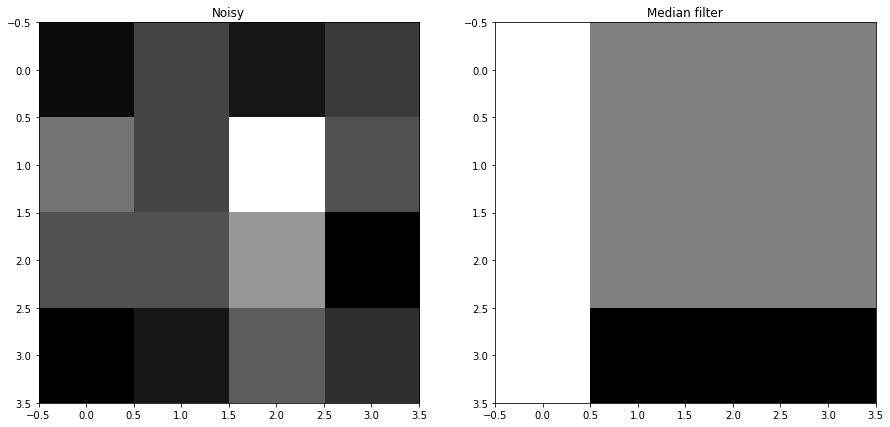

In [10]:
image = np.array([[1,6,2,5],[10,6,22,7],[7,7,13,0],[0,2,8,4]], dtype=np.uint8)
w_window = 2
print(median_filter(image, w_window))

<font color='blue'>**Expected output:**  </font>

    [[6 5 5 5]
     [6 5 5 5]
     [6 5 5 5]
     [6 4 4 4]]

Now play a bit with the parameters of the algorithm!

In [11]:
# Interact with the window size
noisy_img = cv2.imread(images_path + 'noisy_2.jpg', 0)
interactive(median_filter, image=fixed(noisy_img), w_window=(1,5,1), verbose=fixed(True))

interactive(children=(IntSlider(value=3, description='w_window', max=5, min=1), Output()), _dom_classes=('widg…

### <font color="blue"><b><i>Thinking about it (4)</i></b></font>

**You are asked to** try **median_filter** using both noisy images `noisy_1.jpg` and `noisy_2.jpg`. Then, **answer following questions**:

- Is the noise removed from the first image?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Dependiendo del valor que demos al parámetro 'w_window' veremos que somos capaces de eliminar en gran medida el ruido Gaussiano a costa de hacer la imagen demasiado borrosa, llegando incluso a estar peor (menos reconocible) tras haber aplicado el filtro de la media. </i></p>

- Is the noise removed from the second image?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>En este caso también somos capaces de hacer desaparecer el ruido de Sal y Pimienta incluso con valores pequeños del parámetro.</i></p>

- Which value is a good choice for `w_window`? Why?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>La elección de un buen valor para w_window es indispensable si no queremos sacrificar la valiosa información que proporciona la imagen al intentar repararla. A mayor valor del parámetro más se nubla la imagen, pero se obtiene un mayor grado de reducción del ruido.</i></p>
   
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Basado en un sistema de prueba y error, podemos concluir que el rango óptimo para cada imagen es:</i></p>
    
    <p style="margin: 4px 0px 6px 5px; color:blue"><i></i>Noisy1. w_window = 1 ó 2 </p>
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Noisy2. w_window = 1</i></p>

## 2.2.3 Image average

Next, we asked UMA for the possibility to change their camera from a single shot mode to a multi-shot sequence of images. This is a continuous shooting mode also called *burst mode*. They were very kind and provided us with the sequences `burst1_(0:9).jpg` and `burst2_(0:9).jpg` for testing.

Image sequences allow the usage of **image averaging** for noise removal, the last technique we are going to try. In this technique the content of each pixel in the final image is the result of averaging the value of that pixel in the whole sequence. Remark that, in the context of our application, this technique will work only if the car is fully stopped!  

The idea behind image averaging is that using a high number of noisy images from a still camera in a static scene, the resultant image would be noise-free. This is supposed because some types of noise usually has zero mean. Mathematically:

<img src="./images/average_1.png" width="700">

$$
g(x,y) = 
\frac{1}{M} \sum_{i=1}^M f_i(x,y) = 
\frac{1}{M} \sum_{i=1}^M [f_{\text{noise_free}}(x,y)+n_i(x,y)] = \\
= f_{\text{noise_free}}(x,y) + \frac{1}{M} \sum_{i=1}^M n_i(x,y)
$$

This method:
- is very effective with gaussian noise, and 
- it also preserves edges. 

On the contrary: 
- it doesn't work well with salt&pepper noise, and
- it is only applicable for sequences of images from a still scene. 

### **<span style="color:green"><b><i>ASSIGNMENT 5: And last but not least, image averaging</i></b></span>**

We want to analyze the suitability of this method for our application, so you have to complete the `image_averaging()` method. It takes:
- a sequence of images structured as an array with dimensions [sequence length $\times$ height $\times$ width], and 
- the number of images that are going to be used.

*Tip: Get inspiration from here: [average of an array along a specified axis](https://docs.scipy.org/doc/numpy-1.9.2/reference/generated/numpy.average.html)*

In [12]:
# ASSIGNMENT 5
# Implement a function that:
# -- takes a number of images of the sequence (burst_length)
# -- averages the vale of each pixel in the selected part of the sequence
# -- displays the first image in the sequence and the final, filtered one in a 1x2 plot if verbose = True
# -- returns the average image
def image_averaging(burst, burst_length, verbose=True):
    """ Applies image averaging to a sequence of images and display it.   

        Args:
            burst: 3D array containing the fully image sequence.
            burst_length: Natural number indicating how many images are 
                          going to be used. 
            verbose: Only show images if this is True
                
        Returns:
            average_img: smoothed image 
    """
    
    #Take only `burst_length` images
    burst = burst[:burst_length,:,:]
    
    # Apply image averaging
    average_img = np.average(burst, axis=0)
    
    # Change data type to 8-bit unsigned, as expected by plt.imshow()
    average_img = average_img.astype(np.uint8)
    
    if verbose:
        # Show the initial image
        plt.subplot(121)
        plt.imshow(image, cmap='gray')
        plt.title('Noisy')

        # Show the resultant one
        plt.subplot(122)
        plt.imshow(average_img, cmap='gray')
        plt.title('Image averaging')
    
    return average_img

You can use the next code to **test if your results are correct**:

[[ 4  6  7  2]
 [ 5  4 15  5]
 [ 4  6  7  2]
 [ 5  4 15  5]]


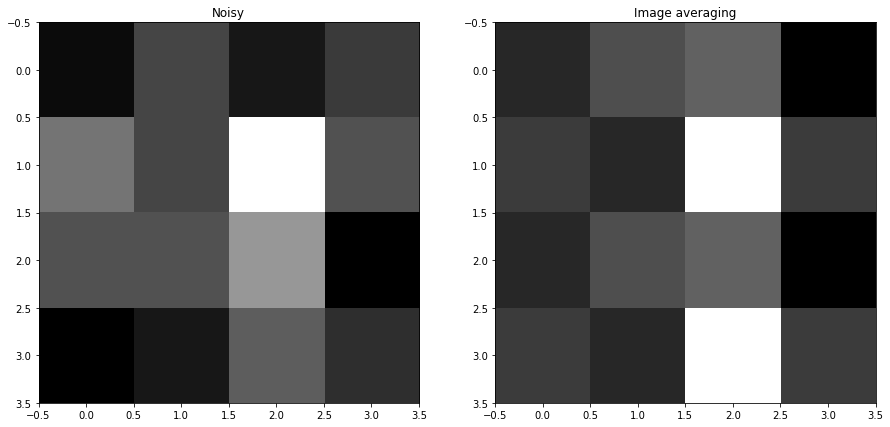

In [13]:
burst = np.array([[[1,6,2,5],[10,6,22,7],[7,7,13,0],[0,2,8,4]],
                  [[7,7,13,0],[0,2,8,4],[1,6,2,5],[10,6,22,7]],
                  [[7,7,13,0],[0,2,8,4],[1,6,2,5],[10,6,22,7]]],dtype=np.uint8)

print(image_averaging(burst, 2))

<font color='blue'>**Expected output:**  </font>

    [[ 4  6  7  2]
     [ 5  4 15  5]
     [ 4  6  7  2]
     [ 5  4 15  5]]

Now check how the number of images used affect the noise removal (play with both sequences):

In [14]:
# Interact with the burst length
# Read image secuence
burst = []
for i in range(10):
    burst.append(cv2.imread('./images/burst1_' + str(i) + '.jpg', 0))
    
# Cast to array
burst = np.asarray(burst)

interactive(image_averaging, burst=fixed(burst), burst_length=(1, 10, 1), verbose=fixed(True))

interactive(children=(IntSlider(value=5, description='burst_length', max=10, min=1), Output()), _dom_classes=(…

### <font color="blue"><b><i>Thinking about it (5)</i></b></font>

**You are asked to** try **image_averaging** with `burst1_XX.jpg` and `burst2_XX.jpg` sequences. Then, **answer these questions**:

- Is the noise removed in both sequences?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Sí, cabe destacar que en ambas secuencias el aumento de 'burst_length' conlleva una mejoría en la reducción del ruido, pero esto se produce de manera más notoria en la segunda secuencia (especialmente en valores bajos).</i></p>

- What number of photos should the camera take in each image sequence?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>En la primera secuencia es suficiente con un valor de 3, que es relativamente bajo. Por otro lado, la segunda secuencia sí que requiere de un valor más alto como puede ser 6.</i></p>

## 2.2.4 Choosing a smoothing technique

The next code cell runs the explored smoothing techniques and shows the results provided by each one while processing two different car license plates, **with two different types of noise. Check them!**

<ipython-input-3-446c4c3c40dc>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)
<ipython-input-3-446c4c3c40dc>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(122)
<ipython-input-6-8e7e50ca96d4>:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.

Text(0.5, 1.0, 'Image averaging')

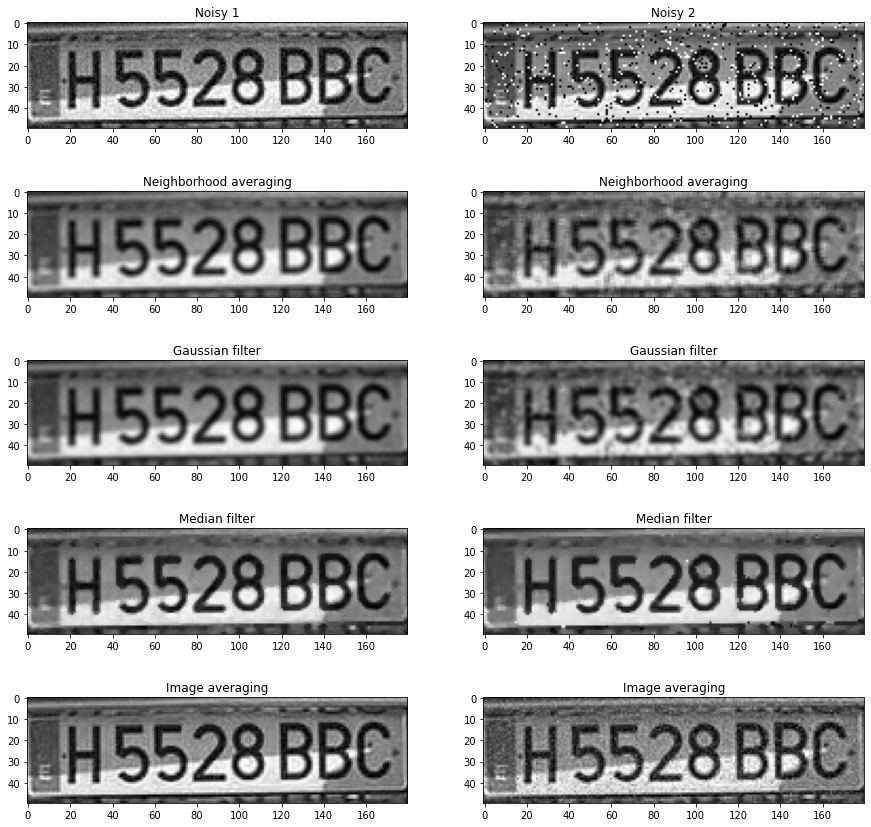

In [15]:
#Read first noisy image
im1 = cv2.imread('./images/burst1_0.jpg', 0)
im1 = im1[290:340,280:460]

# Read second noisy image
im2 = cv2.imread('./images/burst2_0.jpg', 0)
im2 = im2[290:340,280:460]

# Apply neighborhood averaging
neighbor1 = average_filter(im1, 1)
neighbor2 = average_filter(im2, 1)

# Apply Gaussian filter
gaussian1 = gaussian_filter(im1, 2,1)
gaussian2 = gaussian_filter(im2, 2,1)

# Apply median filter
median1 = median_filter(im1, 1)
median2 = median_filter(im2, 1)

# Apply image averaging
burst1 = []
burst2 = []
for i in range(10):
    burst1.append(cv2.imread('./images/burst1_' + str(i) + '.jpg', 0))
    burst2.append(cv2.imread('./images/burst2_' + str(i) + '.jpg', 0))
    
burst1 = np.asarray(burst1)
burst2 = np.asarray(burst2)

burst1 = burst1[:,290:340,280:460]
burst2 = burst2[:,290:340,280:460]

average1 = image_averaging(burst1, 10)
average2 = image_averaging(burst2, 10)

# Plot results
plt.subplot(521)
plt.imshow(im1, cmap='gray')
plt.title('Noisy 1')

plt.subplot(522)
plt.imshow(im2, cmap='gray')
plt.title('Noisy 2')

plt.subplot(523)
plt.imshow(neighbor1, cmap='gray')
plt.title('Neighborhood averaging')

plt.subplot(524)
plt.imshow(neighbor2, cmap='gray')
plt.title('Neighborhood averaging')

plt.subplot(525)
plt.imshow(gaussian1, cmap='gray')
plt.title('Gaussian filter')

plt.subplot(526)
plt.imshow(gaussian2, cmap='gray')
plt.title('Gaussian filter')

plt.subplot(527)
plt.imshow(median1, cmap='gray')
plt.title('Median filter')

plt.subplot(528)
plt.imshow(median2, cmap='gray')
plt.title('Median filter')

plt.subplot(529)
plt.imshow(average1, cmap='gray')
plt.title('Image averaging')

plt.subplot(5,2,10)
plt.imshow(average2, cmap='gray')
plt.title('Image averaging')

### <font color="blue"><b><i>Thinking about it (6)</i></b></font>

And the final question is:

- **What method would you choose** for a final implementation in the system? *Why?*

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Si tuviera que elegir un único método que fuera capaz de desenvolverse bien ante cualquier tipo de ruido, indudablemente sería 'median_filter' ya que es capaz de dar grandes resultados con respecto a la eliminación de ruido introduciendo mínimamente suavizado en los bordes.</i></p>
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Su mayor compertidor es 'image_averaging', pero en la práctica proporciona un resultado bastante similar a costa de necesitar más de una sola imagen. Este requerimiento extra puede suponer un problema para nuestro sistema de reconocimiento de matrículas de la UMA ya que puede darse el caso de que no dispongamos de oportuidad de realizar una serie de imagenes a la placa del vehículo.</i></p>

## Conclusion

That was a complete and awesome job! Congratulations, you learned:

- how to reduce noise in images, for both salt & pepper and Gaussian noise,
- which methods are useful for each type of noise and which not, and
- to apply convolution and efficient implementations of some kernels.

If you want to improve your knowledge about noise in digital images, you can surf the internet for *speckle noise* and *Poisson noise*. 